# Can we detect RS Oph astrometric wobble?

## Jeff J. Andrews

We want to determine if, through adaptive optics, we can correctly identify the inclination angle of the symbiotic binary RS Oph. Essentially, it involves detecting the astrometric wobble from the orbit of the system. 

In [195]:
import numpy as np
import os
import emcee
import corner
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from scipy.optimize import newton
from astropy.coordinates import SkyCoord as Coord
from scipy.stats import norm
import pickle

%matplotlib inline

In [2]:
# Constants in cgs
Msun = 1.989e33 
G = 6.674e-8
secday = 3600.0*24.0
secyer = 3600.0*24.0*365.25
AUincm = 1.496e13 
pcincm = 3.086e18

# RS Oph - Assume position is barycentric
RS_oph_coor = Coord('17h50m13.2s', '-06d42m28s')
alpha = RS_oph_coor.ra.degree
delta = RS_oph_coor.dec.degree
distance = 1.6e3 * pcincm # 1.6 kpc

### Define some functions

In [3]:
# Function to get the true anomaly
def get_f(p, t_set):
    
    RS_ra, RS_dec, Omega, omega, I, tau, e, P, gamma, M1, M2 = p
    
    mu = G * (M1 + M2)
    n = 2.0*np.pi / P
    A = np.power(mu/(n*n), 1.0/3.0)

    
    def func_E(x,n,t,tau,e):
        return n*(t-tau) - x + e*np.sin(x)
    
    E_set = np.array([])
    if isinstance(t_set, np.ndarray):
        for t in t_set:
            E_set = np.append(E_set, newton(func_E, t, args=(n,t,tau,e)))
    else:
        E_set = np.append(E_set, newton(func_E, t_set, args=(n,t_set,tau,e)))
    
    f_set = np.array([])
    for E in E_set:
        f = np.arccos((np.cos(E)-e)/(1.0-e*np.cos(E)))
        if np.sin(E) < 0:
            f = 2.0*np.pi - f
            
        f_set = np.append(f_set, f)
            
    
    return f_set

In [4]:
# Function to get the r component of the velocity
def get_r_dot(p, t):
    
    RS_ra, RS_dec, Omega, omega, I, tau, e, P, gamma, M1, M2 = p
    
    mu = G * (M1 + M2)
    n = 2.0*np.pi / P
    A = np.power(mu/(n*n), 1.0/3.0)
    f = get_f(p, t)
    
    r_dot = A * e * np.sin(f) / np.sqrt(1.0 - e*e) * n
    
    return r_dot

In [5]:
# Function to get the phi component of the velocity (?)
def get_r_f_dot(p, t):
    
    RS_ra, RS_dec, Omega, omega, I, tau, e, P, gamma, M1, M2 = p
    
    mu = G * (M1 + M2)
    n = 2.0*np.pi / P
    A = np.power(mu/(n*n), 1.0/3.0)
    f = get_f(p, t)

    r_f_dot = n * A / np.sqrt(1.0 - e*e) * (1.0 + e*np.cos(f))
    
    return r_f_dot

In [99]:
# Radial velocity
def get_RV(p, t):

    RS_ra, RS_dec, Omega, omega, I, tau, e, P, gamma, M1, M2 = p
    
    mu = G * (M1 + M2)
    n = 2.0*np.pi / P
    A = np.power(mu/(n*n), 1.0/3.0)
    f = get_f(p, t)

    r_dot = get_r_dot(p, t)
    r_f_dot = get_r_f_dot(p, t)
    
    # Get two RV components (these are in cm/s)
    rv_1 = r_dot * M2 / (M1+M2) * (np.cos(Omega)*np.cos(omega+f) - np.sin(Omega)*np.sin(omega+f)*np.cos(I))
    rv_2 = r_f_dot * M2 / (M1+M2) * (np.cos(Omega)*np.sin(omega+f) + np.sin(Omega)*np.cos(omega+f)*np.cos(I))

    # RV is in km/s
    rv = (rv_1 - rv_2) / 1.0e5
        
    # Adjust for system's radial velocity
    rv = rv + gamma
        
    return rv

In [7]:
# Function to get astrometry for a particular orbital solution and time

def get_ra_dec(p, t):
    RS_ra, RS_dec, Omega, omega, I, tau, e, P, gamma, M1, M2 = p

    mu = G * (M1 + M2)
    n = 2.0*np.pi / P
    A = np.power(mu/(n*n), 1.0/3.0)
    f = get_f(p, t)

    # Get the distance from M2 to the barycenter
    sep = A * (1.0 - e**2) / (1.0 + e * np.cos(f)) * (M1 / (M1+M2))
    
    d_alpha = sep * (np.cos(Omega)*np.cos(omega+f) - np.sin(Omega)*np.sin(omega+f)*np.cos(I)) / distance
    d_delta = sep * (np.sin(Omega)*np.cos(omega+f) + np.cos(Omega)*np.sin(omega+f)*np.cos(I)) / distance
        
    alpha_out = RS_ra + d_alpha * (180.0/np.pi)
    delta_out = RS_dec + d_delta * (180.0/np.pi)

    return alpha_out, delta_out
    

### Create a test orbit

In [8]:
# Orbital period is set
P_test = 460.0 * secday # days

RS_ra = alpha
RS_dec = delta
M1_test = 1.0 * Msun
M2_test = 1.2 * Msun
e_test = 0.5
I_test = np.pi/180.0 * 30.0 # inclination angle (degrees)
omega_test = np.pi/180.0 * 20.0 # (degrees)
Omega_test = np.pi/180.0 * 30.0 # (degrees)
tau_test = 0.4*P_test
gamma_test = 0.0

p = RS_ra, RS_dec, Omega_test, omega_test, I_test, tau_test, e_test, P_test, gamma_test, M1_test, M2_test

In [115]:
# Observe at an average Gaia cadence of 70 times in 5 years
t_obs = np.linspace(0.0, 5.0*P_test-1.0, 70)

# Get position
ra_out, dec_out = get_ra_dec(p, t_obs)
ra_diff = (ra_out - RS_ra) * 3600.0 * 1.0e3   # position difference in milliarcsec
dec_diff = (dec_out - RS_dec) * 3600.0 * 1.0e3  # position difference in milliarcsec

# Add uncertainties to get "observed" values
obs_err = 0.024
ra_diff_obs = ra_diff + norm.rvs(loc=0.0, scale=obs_err, size=len(ra_diff)) 
dec_diff_obs = dec_diff + norm.rvs(loc=0.0, scale=obs_err, size=len(ra_diff)) 

# Get radial velocities
rv_err = 10.0
rv = get_RV(p, t_obs) + norm.rvs(loc=0.0, scale=rv_err, size=len(t_obs))

# Copy "observations" to a numpy array
names = ["time","ra","dec","ra_err","dec_err","rv","rv_err"]
obs_pos = np.recarray(len(ra_diff_obs), names=names, formats=['float64,float64,float64,float64,float64,float64,float64'])
obs_pos["time"] = t_obs
obs_pos["ra"] = ra_diff_obs/(3600.0*1.0e3) + RS_ra
obs_pos["dec"] = dec_diff_obs/(3600.0*1.0e3) + RS_dec
obs_pos["ra_err"] = obs_err
obs_pos["dec_err"] = obs_err
obs_pos["rv"] = rv
obs_pos["rv_err"] = rv_err

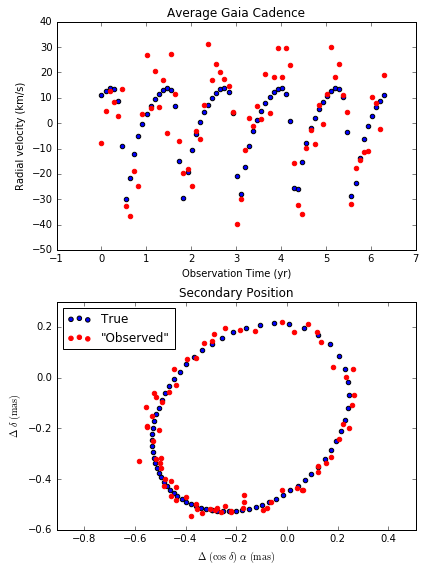

In [202]:
fig = plt.figure(figsize=(6, 8))

ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

#plt.subplot(1,2,1)
ax1.set_title('Average Gaia Cadence')
ax1.scatter(t_obs/secyer, get_RV(p, t_obs))
ax1.scatter(t_obs/secyer, obs_pos["rv"], color='r')
ax1.set_xlabel("Observation Time (yr)")
ax1.set_ylabel("Radial velocity (km/s)")
#plt.show()


#plt.subplot(1,2,2)
ax2.set_title("Secondary Position")
ax2.scatter(ra_diff, dec_diff, label="True")
ax2.scatter((obs_pos["ra"]-RS_ra)*(3600.0*1.0e3), (obs_pos["dec"]-RS_dec)*(3600.0*1.0e3), 
            color='r', label="\"Observed\"")
ax2.get_axes().set_aspect('equal', 'datalim')

ax2.set_xlabel(r'$\Delta\ (\cos\ \delta)\ \alpha\ ({\rm mas})$')
ax2.set_ylabel(r'$\Delta\ \delta\ ({\rm mas})$')

ax2.legend(loc=2)

plt.tight_layout()

plt.savefig('../figures/RS_oph_pos_rv_gaia.pdf')
#plt.show()

In [139]:
# The posterior function calls the likelihood and prior functions
def ln_posterior(p, obs_pos):
 

    # Check prior on model first
    lp = ln_prior(p)
    
    if np.isnan(lp) or np.isinf(lp):
        return -np.inf

    # Then check likelihood of parameters
    ll = 0.0
    ll = ll + ln_likelihood_rv(p, obs_pos[0])
    ll = ll + ln_likelihood_pos(p, obs_pos[0])
    
    if np.any(np.isnan(ll) | np.isinf(ll)):
        return -np.inf
    
    if np.all(ll == 0.):
        return -np.inf
    
    return lp + ll.sum()




In [92]:
# Prior on parameters
def ln_prior(p):

    RS_ra, RS_dec, Omega, omega, I, tau, e, P, gamma, M1, M2 = p
    
    lp = 0.
    
    # Angles bound between 0 and 2pi
    if Omega < 0. or Omega > np.pi:
        return -np.inf
    if omega < 0. or omega > 2.0*np.pi:
        return -np.inf
    
    # Needs to discern between left-handed and right-handed
    if I < 0. or I > 2.0*np.pi:
        return -np.inf

    # Zero point needs to be constrained to first orbital period
    if tau < 0. or tau > P_test:
        return -np.inf
    
    # Eccentricity keeps the system bound
    if e < 0. or e > 1.0:
        return -np.inf
    
    # Period
    if P < 1.0e4 or P > 1.0e10:
        return -np.inf
    
    # Gamma
    if gamma < -1000.0 or gamma > 1000.0:
        return -np.inf
    
    # Constrain mass around 1 Msun
    if M1 < 0.5*Msun or M1 > 3.5*Msun:
        return -np.inf
    if M2 < 0.5*Msun or M2 > 3.5*Msun:
        return -np.inf

    # Prior on inclination angle
    lp = lp + np.log(np.sin(I)/2.0)
    
#     # Keep P above 1 hour, less than 1 week
#     if P < 3600.0 or P > secday*7.0:
#         return -np.inf

#     if gamma < -1.0e7 or gamma > 1.0e7:
#         return -np.inf
    
    return lp

    

In [93]:
def ln_likelihood_rv(p, obs_rv):
    
    RS_ra, RS_dec, Omega, omega, I, tau, e, P, gamma, M1, M2 = p
    
    rv_model = get_RV(p, obs_rv["time"])
    
    # P( delta t_cool | M1_zams_t, M2_zams_t)
    coeff = 1./(obs_rv["rv_err"] * np.sqrt(2. * np.pi))
    argument = np.exp(-(rv_model - obs_rv["rv"])*(rv_model - obs_rv["rv"])/(2. * obs_rv["rv_err"]*obs_rv["rv_err"]))

    ln_P_temp = np.log(coeff * argument)
    
    return np.sum(ln_P_temp)

In [94]:
def ln_likelihood_pos(p, obs_pos):
    RS_ra, RS_dec, Omega, omega, I, tau, e, P, gamma, M1, M2 = p
        
    # Calculate position
    obs_time = obs_pos["time"]
    ra_out, dec_out = get_ra_dec(p, obs_time)
#    ra_diff = (ra_out - RS_ra) * 3600.0 * 1.0e3   # position difference in milliarcsec
#    dec_diff = (dec_out - RS_dec) * 3600.0 * 1.0e3  # position difference in milliarcsec

    ra_diff = (ra_out - obs_pos["ra"]) * 3600.0 * 1.0e3
    dec_diff = (dec_out - obs_pos["dec"]) * 3600.0 * 1.0e3
    
#    ra_diff_obs = (obs_pos["ra"] - RS_ra) * 3600.0 * 1.0e3
#    dec_diff_obs = (obs_pos["dec"] - RS_dec) * 3600.0 * 1.0e3
        
    ln_prob_ra = -np.log(obs_pos["ra_err"] * np.sqrt(2.0*np.pi)) - ra_diff**2/(2.0*obs_pos["ra_err"]**2)
    ln_prob_dec = -np.log(obs_pos["dec_err"] * np.sqrt(2.0*np.pi)) - dec_diff**2/(2.0*obs_pos["dec_err"]**2)
    
    
    return np.sum(ln_prob_ra) + np.sum(ln_prob_dec)
    
    

In [117]:
# This function runs emcee
def run_inference(obs_pos, nwalkers=32, nburn=10, nsteps=10):
    # number of parameters
    ndim = 11

    # initial positions for walkers
    p0 = np.zeros((nwalkers,ndim))
    p0[:,0] = RS_ra + np.random.normal(0.0, 1.0e-8, size=nwalkers) # RA
    p0[:,1] = RS_dec + np.random.normal(0.0, 1.0e-8, size=nwalkers) # Dec
    p0[:,2] = Omega_test + np.random.normal(0.0, 1.0e-2, size=nwalkers)  # Omega
    p0[:,3] = omega_test + np.random.normal(0.0, 1.0e-2, size=nwalkers)  # omega
    p0[:,4] = I_test + np.random.normal(0.0, 1.0e-2, size=nwalkers)  # I
    p0[:,5] = tau_test + np.random.normal(0.0, 1.0e-2, size=nwalkers)  # tau
    p0[:,6] = e_test + np.random.normal(0.0, 1.0e-3, size=nwalkers) # e
    p0[:,7] = P_test + np.random.normal(0.0, 1.0e2, size=nwalkers) # P
    p0[:,8] = 100.0 * np.random.uniform(size=nwalkers) # gamma
    p0[:,9] = Msun*np.random.normal(1.0, 0.2, size=nwalkers) # M1
    p0[:,10] = Msun*np.random.normal(1.0, 0.2, size=nwalkers) # M2
    
    # Make sure all walkers are in a valid point of parameter space
    for i in np.arange(nwalkers):
        
        ln_p_i = ln_posterior(p0[i], obs_pos)
        
        j = 0
        while (np.isinf(ln_p_i)):
            if j > 100: break

            p0[i,0] = RS_ra + np.random.normal(0.0, 1.0e-8, size=1) # RA
            p0[i,1] = RS_dec + np.random.uniform(0.0, 1.0e-8, size=1) # RA
            p0[i,2] = Omega_test + np.random.normal(0.0, 1.0e-2, size=1)  # Omega
            p0[i,3] = omega_test + np.random.normal(0.0, 1.0e-2, size=1)  # omega
            p0[i,4] = I_test + np.random.normal(0.0, 1.0e-2, size=1)  # I
            p0[i,5] = tau_test + np.random.normal(0.0, 1.0e-2, size=1)  # tau
            p0[i,6] = e_test + np.random.normal(0.0, 1.0e-3, size=1) # e
            p0[i,7] = P_test + np.random.normal(0.0, 1.0e2, size=1) # P
            p0[i,8] = 100.0 * np.random.uniform(size=1) # gamma
            p0[i,9] = Msun*np.random.normal(1.0, 0.2, size=1) # M1
            p0[i,10] = Msun*np.random.normal(1.0, 0.2, size=1) # M2

            ln_p_in = ln_posterior(p0[i], obs_pos)
            
            j = j + 1

    
    
    print "Initial positions found"
    
    args = [[obs_pos]]
    sampler = emcee.EnsembleSampler(nwalkers=nwalkers, dim=ndim, lnpostfn=ln_posterior, args=args)

    # burn-in
    sampler.run_mcmc(p0, N=nburn)
    pos,prob,state = sampler.run_mcmc(p0, N=nburn)

    # throw out burn-in samples
    sampler.reset() 
    pos,prob,state = sampler.run_mcmc(pos, N=nsteps)

    
    return sampler



In [140]:
start = time.time()

#p_start = np.array([1.2, 2.5, 0.8, 15000.0, 0.10, 0.547*secday, 3.0e6])
sampler = run_inference(obs_pos, nwalkers=100, nburn=1000, nsteps=1000)

end = time.time()

print "Mock data set 1 finished. Elapsed time: ", end-start, " seconds"


Initial positions found
Mock data set 1 finished. Elapsed time:  5990.06936693  seconds


In [141]:
pickle.dump( sampler, open( "../data/RS_oph_rv_gaia.obj", "wb" ) )

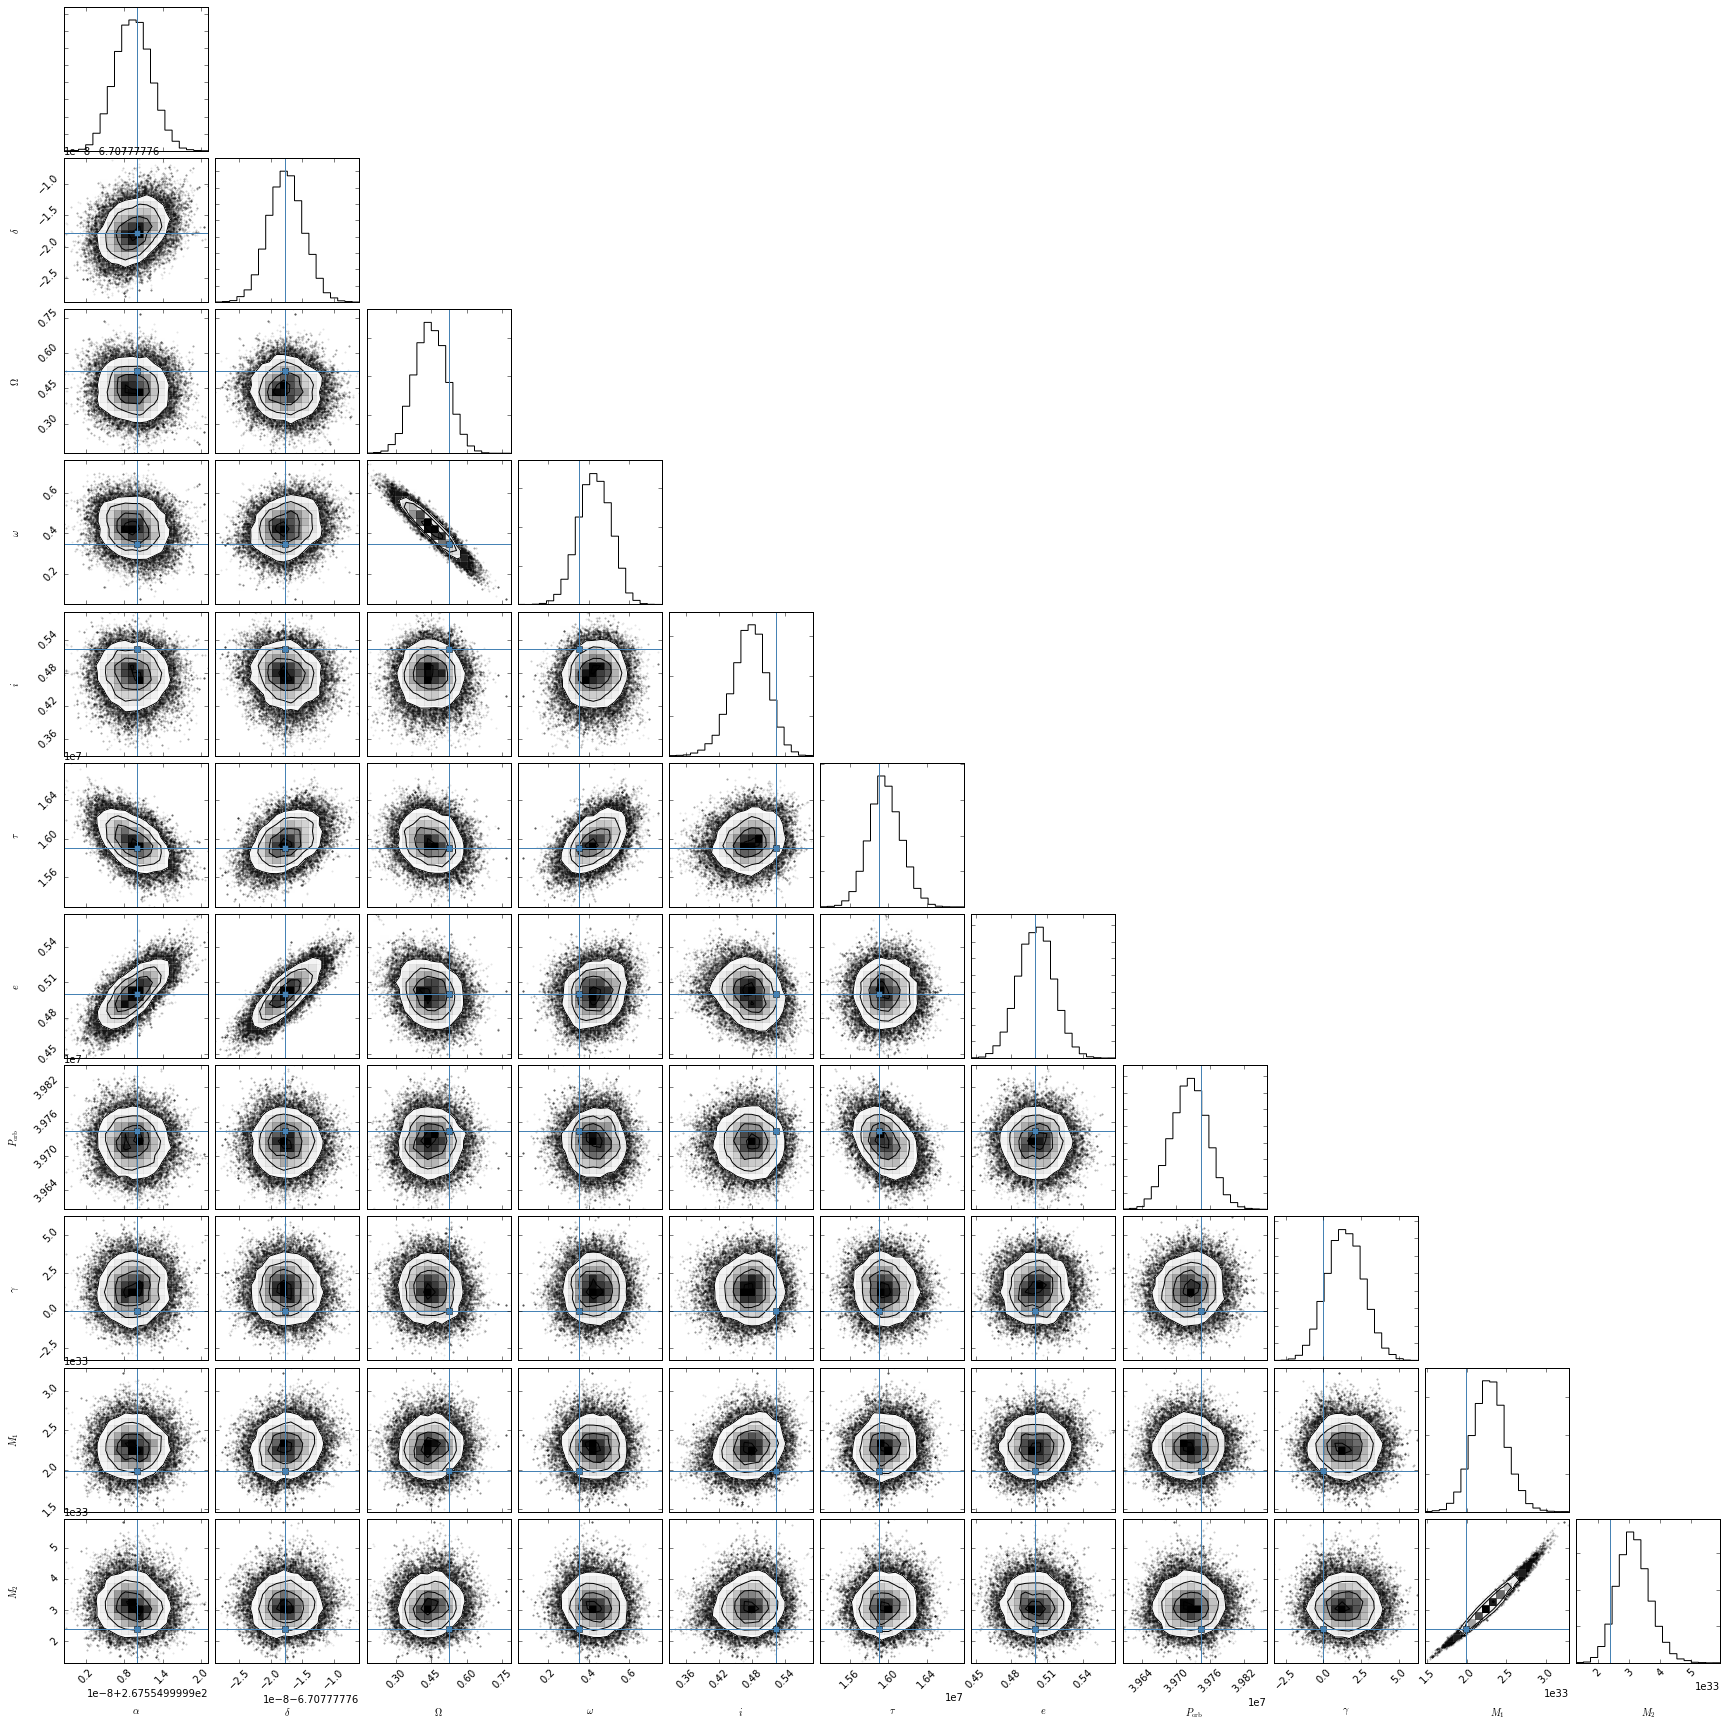

In [142]:
labels = [r"$\alpha$", r"$\delta$", r"$\Omega$", r"$\omega$", r"$i$", r"$\tau$", r"$e$", r"$P_{\rm orb}$", r"$\gamma$", r"$M_1$", r"$M_2$"]
#fig = triangle.corner(sampler_1.flatchain.T[0:4].T, truths=p_true_1, labels=labels)
truths = [RS_ra, RS_dec, Omega_test, omega_test, I_test, tau_test, e_test, P_test, gamma_test, M1_test, M2_test]
fig = corner.corner(sampler.flatchain, truths=truths, labels=labels)

plt.savefig("../figures/RS_oph_corner_rv_gaia.pdf")

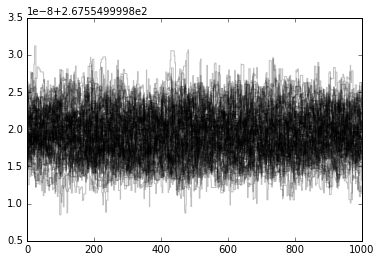

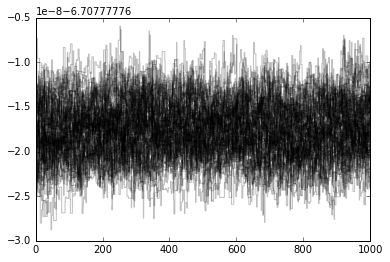

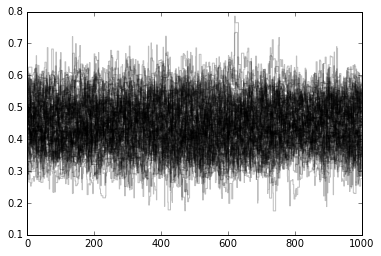

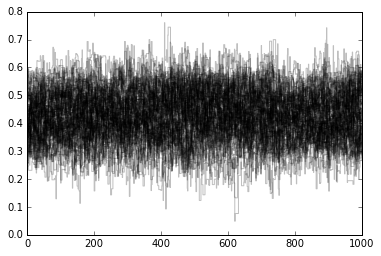

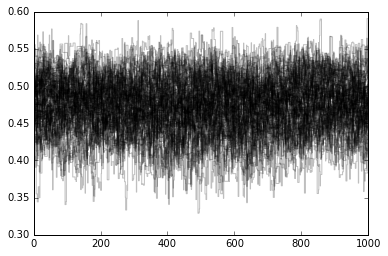

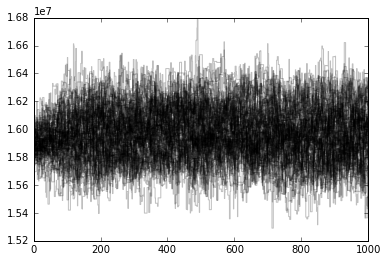

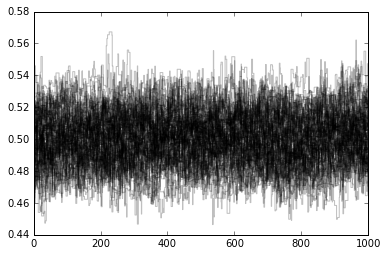

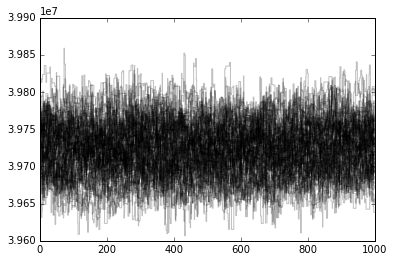

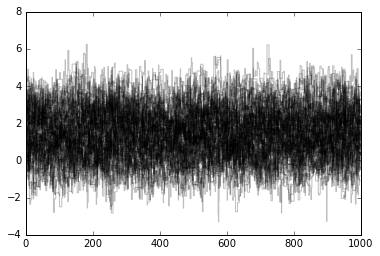

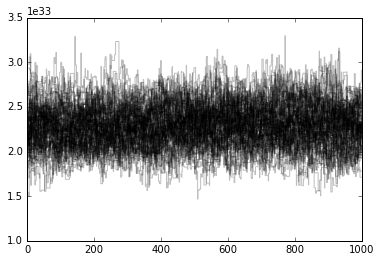

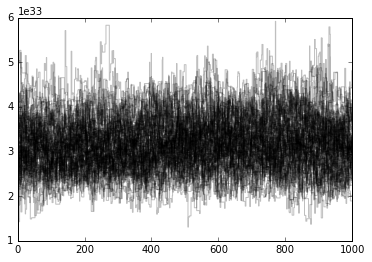

In [143]:
for i in range(sampler.dim):
    plt.figure()
    for chain in sampler.chain[...,i]:
        plt.plot(chain, alpha=0.25, color='k', drawstyle='steps')

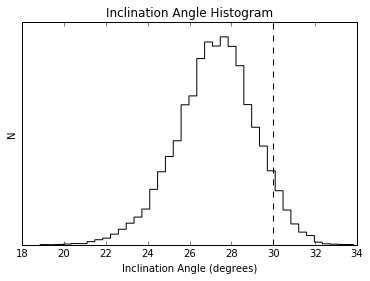

In [144]:

plt.title("Inclination Angle Histogram")
plt.hist(sampler.flatchain.T[4]*180.0/np.pi, histtype='step', color='k', bins=40)
plt.xlabel('Inclination Angle (degrees)')
plt.axvline(I_test*180.0/np.pi, color='k', linestyle='dashed')
plt.yticks([])
plt.ylabel("N")

#plt.savefig('../figures/RS_oph_gaia_hist_i.pdf')
plt.show()

In [153]:
sampler_no_rv = pickle.load( open("../data/RS_oph_gaia.obj", "rb"))
sampler_rv = sampler

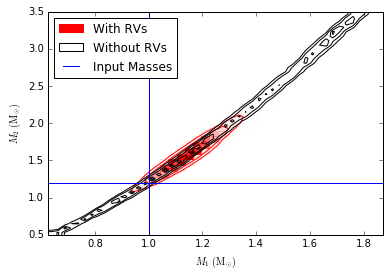

In [199]:
corner.hist2d(sampler_rv.flatchain.T[9]/Msun, sampler_rv.flatchain.T[10]/Msun, bins=30, 
              color='r', plot_datapoints=False, plot_density=True, smooth=0.5)
plt.xlabel(r'$M_1\ ({\rm M}_{\odot})$')
plt.ylabel(r'$M_2\ ({\rm M}_{\odot})$')

contourf_kwargs = {"linewidths":4}
contour_kwargs = {"linestyles":"dashed"}
corner.hist2d(sampler_no_rv.flatchain.T[9]/Msun, sampler_no_rv.flatchain.T[10]/Msun, bins=50, 
              plot_density=False, no_fill_contours=True, plot_datapoints=False, smooth=0.1, 
              **contour_kwargs)

plt.axvline(M1_test/Msun, color='b')
plt.axhline(M2_test/Msun, color='b')

red_patch = mpatches.Patch(color='red', label='With RVs')
black_patch = mpatches.Patch(color='k', label='Without RVs', fill=False)
blue_line = mlines.Line2D([0.0,1.0],[0.5,0.5],color='b', label="Input Masses")
plt.legend(handles=[red_patch, black_patch, blue_line], loc=2)


plt.savefig('../figures/RS_oph_gaia_dist_M1_M2.pdf')
#plt.show()

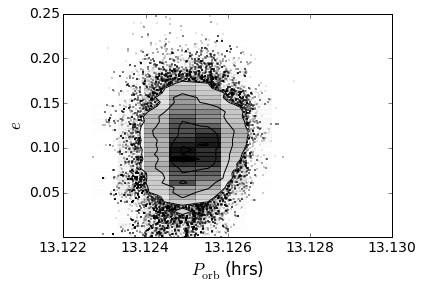

In [36]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
plt.rcParams.update({'axes.labelsize': 'large'})

tmp_P_orb = sampler.flatchain.T[5][np.where(sampler.flatchain.T[5] > 47200.0)] / secday * 24.0
tmp_ecc = sampler.flatchain.T[4][np.where(sampler.flatchain.T[5] > 47200.0)]

triangle.hist2d(tmp_P_orb, tmp_ecc)

plt.xlim(13.122, 13.13)
plt.xticks(np.linspace(13.122, 13.13,5))
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.ylim(0.001, 0.25)

plt.xlabel(r'$P_{\rm orb}$ (hrs)')
plt.ylabel(r'$e$')

plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15, left=0.15)


#plt.savefig('./figures/P_e.pdf')
plt.show()

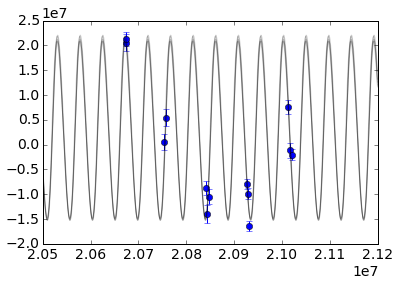

In [37]:
samples = sampler.flatchain

# Select 50 random samples from the posterior distribution
posterior_samples = np.array([])
for p0, p1, p2, p3, p4, p5, p6 in samples[np.random.randint(len(samples),size=5)]:
    p = np.array([p0, p1, p2, p3, p4, p5, p6, M1, M2])
    posterior_samples = np.append(posterior_samples, p)
posterior_samples.shape = (5,9)




plt.errorbar(rv["time"], rv["rv"], yerr=rv["rv_err"], fmt='o')

for p in posterior_samples:
#p = posterior_samples[2]
#p = (0.0, 0.0, 0.0, 2.05e7, 0.0, secday*0.54, 0.0, M1, M2)

    tmp_x = np.linspace(2.05e7, 2.12e7, 1000)
    tmp_y = get_RV(p, tmp_x)  
    plt.plot(tmp_x,tmp_y, alpha=0.2, color='k')

plt.xlim(2.05e7,2.12e7)

plt.show()

WD peak-to-peak velocity difference:  371.647400899  km/s
NS peak-to-peak velocity difference:  61.8421275095  km/s


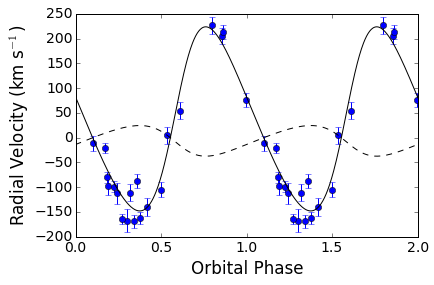

In [39]:
tmp_obs = rv.copy()

posterior_samples = np.array([])
for p0, p1, p2, p3, p4, p5, p6 in samples[np.random.randint(len(samples),size=1)]:
    p = np.array([p0, p1, p2, p3, p4, p5, p6, M1, M2])
    posterior_samples = np.append(posterior_samples, p)
posterior_samples.shape = (1,9)

p = posterior_samples[0]

for obs in tmp_obs:
    
    t_start = posterior_samples[0][3]
    P_orb = posterior_samples[0][5]

    obs["time"] = obs["time"] + t_start
    while obs["time"] > P_orb:
        obs["time"] = obs["time"] - P_orb
    obs["time"] = obs["time"] / P_orb
    
    obs["rv"] = obs["rv"] / 1.0e5
    obs["rv_err"] = obs["rv_err"] / 1.0e5
    

tmp_obs_2 = tmp_obs.copy()
for obs in tmp_obs_2:
    obs["time"] = obs["time"] + 1.0
tmp_obs = np.append(tmp_obs, tmp_obs_2)
    

plt.errorbar(tmp_obs["time"], tmp_obs["rv"], yerr=tmp_obs["rv_err"], fmt='o')  



tmp_x = np.linspace(-1.0 * P_orb , 2.0 * P_orb, 1000)
tmp_y = get_RV(p, tmp_x) / 1.0e5 
tmp_x = (tmp_x + t_start) / P_orb
plt.plot(tmp_x,tmp_y, color='k')

print "WD peak-to-peak velocity difference: ", max(tmp_y) - min(tmp_y), " km/s"


tmp_NS_y = -tmp_y * M1 / M2
plt.plot(tmp_x, tmp_NS_y, color='k', linestyle='--')

print "NS peak-to-peak velocity difference: ", max(tmp_NS_y) - min(tmp_NS_y), " km/s"

    
plt.xlim(0.0, 2.0)

plt.xlabel('Orbital Phase')
plt.ylabel(r'Radial Velocity (km s$^{-1}$)')

plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15, left=0.15)


#plt.savefig('../figures/WD_orb.pdf')
plt.show()

In [10]:
P_orb = 28.0*3600.0

tmp_x = np.linspace(0 , P_orb, 1000)
tmp_y = get_RV(p, tmp_x) / 1.0e5 
tmp_x = tmp_x / 60.0 # change from seconds to minutes
#tmp_x = (tmp_x + t_start) / P_orb
#plt.plot(tmp_x,tmp_y, color='k')

tmp_NS_y = -tmp_y * M1 / M2


P0 = 0.5711963 # Base period in seconds

vel0 = -p[6]/1.0e5 * M1 / M2
dp_temp = (P0 / (1.0 + (tmp_NS_y-vel0)/3.0e5)) - P0

plt.plot(tmp_x, 1000.0*dp_temp, color='k', alpha=0.5)




# Load short cadence radio periods
datafile = os.path.abspath("../data/periods_short.dat")
names = ["time","period","period_err"]
radio_obs_short = np.genfromtxt(datafile, dtype=None, skip_header=1, names=names)
radio_obs_short["time"] = (radio_obs_short["time"]-56808.74) * 24.0 * 60.0


radio_obs = np.array([[340.0, 0.5712563, 0.0000014], [372.0, 0.5712563, 0.0000011]])


radio_obs = radio_obs.T
radio_obs[1] = 1000.0 * radio_obs[1]
radio_obs[2] = 1000.0 * radio_obs[2]
plt.errorbar(radio_obs[0], radio_obs[1]-P0*1000.0, yerr=radio_obs[2], capsize=4, color='k', fmt='o', markersize=0.1, linewidth=1.5)
#plt.errorbar(radio_obs_short["time"], radio_obs_short["period"]-P0, yerr=radio_obs_short["period_err"], color='g', fmt='o', markersize=0.1)

plt.xlabel('Orbital phase (minutes)')
plt.ylabel(r'$\Delta P_{\rm spin}$ (ms)')

#plt.ylim(-2.0e-4,-1.0e-5)
#plt.ylim(-4.8e-4, -3.0e-4)

plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15, left=0.17)

#plt.savefig('../figures/NS_orbit.pdf')
plt.show()

NameError: name 'p' is not defined